## Overview
A regression task with synthetic data generated using a deep learning model trained with the [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html).

## Library Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from folium import Map
from folium.plugins import HeatMap

from sklearn.metrics.pairwise import haversine_distances
from math import radians

import torch
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('whitegrid')

# Uncomment to use AutoML
# !pip install -q flaml
# import flaml

# !pip install -q autogluon
# from autogluon.tabular import TabularPredictor

# from geopy.geocoders import Nominatim

!pip install -q reverse_geocoder
import reverse_geocoder as rg

## Data
Load augmented data with geo places. The commented code is what I used to get them but very slow.

In [2]:
df_train = pd.read_csv('/kaggle/input/s03e01-california/train_geo.csv', index_col=0, dtype={'postcode': str})
df_test = pd.read_csv('/kaggle/input/s03e01-california/test_geo.csv', index_col=0, dtype={'postcode': str})
df_original = pd.read_csv('/kaggle/input/s03e01-california/original_geo.csv', index_col=0, dtype={'postcode': str})

df_train['postcode'] = df_train['postcode'].fillna('0').apply(lambda x: x.replace('-', '.')).astype(float)
df_test['postcode'] = df_test['postcode'].fillna('0').apply(lambda x: x.replace('-', '.')).astype(float)
df_original['postcode'] = df_original['postcode'].fillna('0').apply(lambda x: x.replace('-', '.')).astype(float)

In [3]:
# df_train = pd.read_csv('/kaggle/input/playground-series-s3e1/train.csv', index_col=0)
# df_test = pd.read_csv('/kaggle/input/playground-series-s3e1/test.csv', index_col=0)
# features, target = df_train.columns[:-1], df_train.columns[-1]

# original = fetch_california_housing()
# assert original['feature_names'] == list(features)
# assert original['target_names'][0] == target

# df_original = pd.DataFrame(original['data'], columns=features)
# df_original[target] = original['target']

### Add geo features

# def extract_key(location, k):
#     if not location or not location.raw or not location.raw.get('address'):
#         print(location, 'failed')
#         return None
    
#     return location.raw['address'].get(k) 
    
# def extract_geo_features(lat_lon):
#     location = geolocator.reverse(lat_lon)
#     keys = ['road', 'neighbourhood', 'town', 'county', 'city', 'state_district', 'postcode']
#     return {k:extract_key(location, k) for k in keys}

# locations = list(zip(df_test['Latitude'], df_test['Longitude']))
# results = []
# for idx, loc in enumerate(locations):
#     results.append(extract_geo_features(loc))
#     if idx % 1000 == 999:
#         df_geo = pd.DataFrame(results, index=df.index)
#         df_geo.to_csv(f'test_geo_{idx+1}.csv', index=None)
#         print(idx)
# df_geo = pd.DataFrame(results, index=df.index)
# df_geo = pd.concat((df_test, df_geo), axis=1)
# df_geo.to_csv(f'test_geo_all.csv', index=None)

## EDA

### Missing values

In [4]:
df_train.isna().sum()

MedInc                0
HouseAge              0
AveRooms              0
AveBedrms             0
Population            0
AveOccup              0
Latitude              0
Longitude             0
MedHouseVal           0
road               1920
neighbourhood     32935
town              27959
county             1335
city              14771
state_district    17945
postcode              0
dtype: int64

> There are more missing values with added geo features.

### Distribution

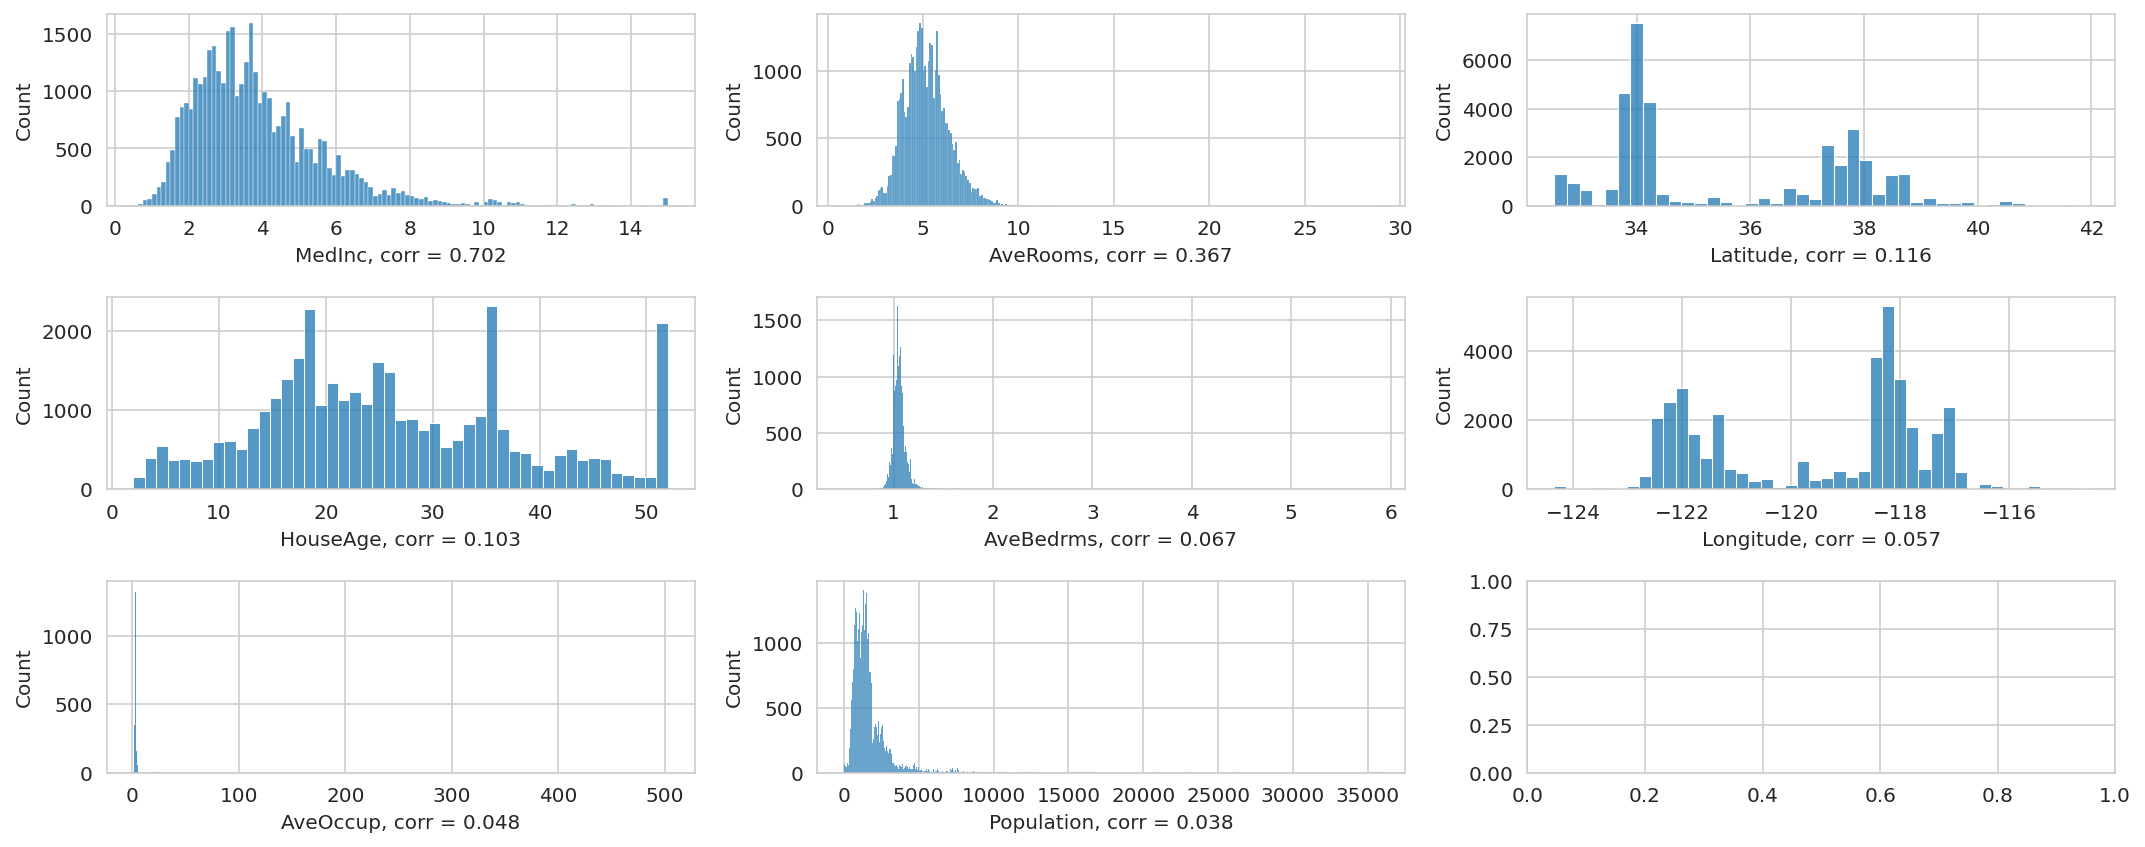

In [5]:
ncols = 3
columns = df_train.columns[:8]
nrows = np.ceil(len(columns)/ncols).astype(int)
target = 'MedHouseVal'
cols = df_train[columns].corrwith(df_train[target]).abs().sort_values(ascending=False)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,nrows*2))

for idx, (c, corr) in enumerate(cols.items()):
    row = idx // ncols
    col = idx % ncols
    sns.histplot(df_train, x=c, ax=axs[row, col])
    axs[row,col].set_xlabel(f'{c}, corr = {corr:.3f}')
plt.tight_layout()

Some observations:
- House value is capped
- MedInc has the highest correlation with house value

### Look at the data on a map
Credit: https://www.kaggle.com/code/jcaliz/ps-s03e01-a-complete-eda

In [6]:
heat_data = [[row['Latitude'],row['Longitude']] for _, row in df_train.iterrows()]
heat_map = Map(df_train[['Latitude', 'Longitude']].mean(axis=0), zoom_start=6) 
HeatMap(heat_data, radius=10).add_to(heat_map)
heat_map

### Compare with original data

In [7]:
df_train['original'] = 0
df_test['original'] = 0
df_original['original'] = 1

df_train['source'] = 'train'
df_test['source'] = 'test'
df_original['source'] = 'original'
df_mixed = pd.concat([df_train, df_test, df_original])

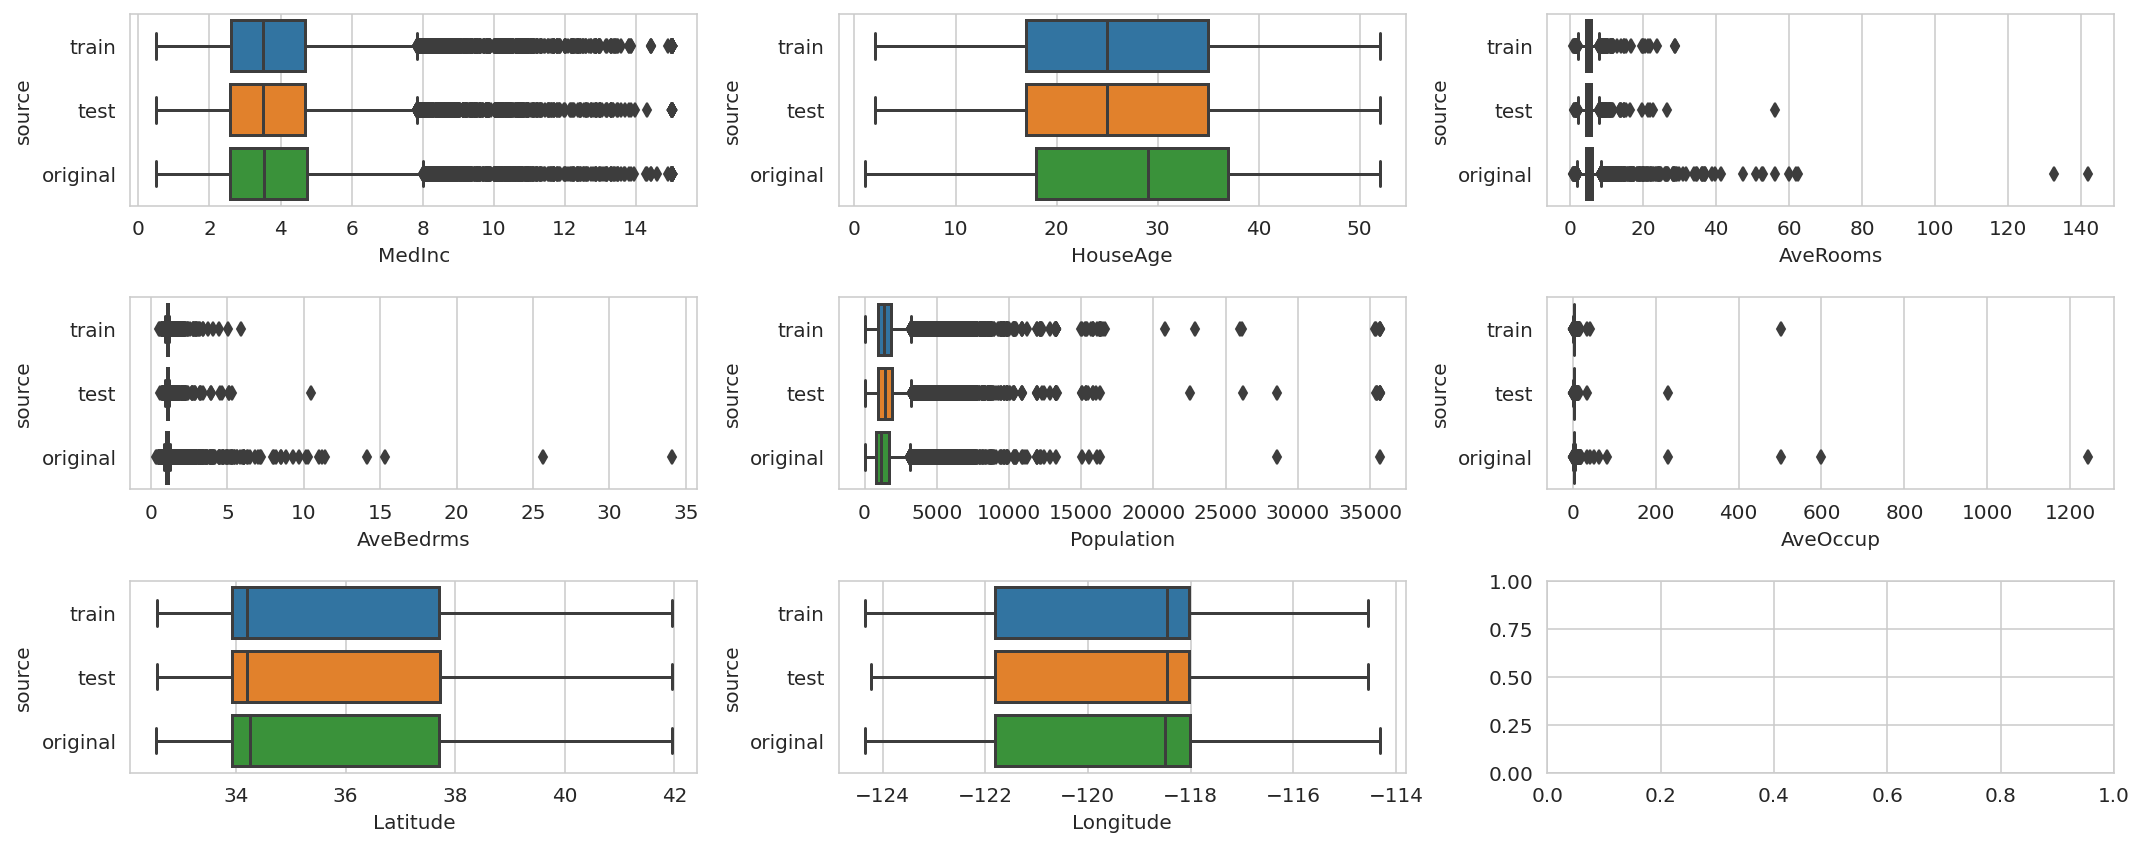

In [8]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,nrows*2))

for idx, c in enumerate(columns):
    row = idx // ncols
    col = idx % ncols
    sns.boxplot(data=df_mixed, x=c, y='source', ax=axs[row, col])
plt.tight_layout()
df_train.drop(columns=['source'], inplace=True)
df_test.drop(columns=['source'], inplace=True)
df_original.drop(columns=['source'], inplace=True)

They look pretty similar. `HouseAge` is a little bit off. Some variables have outliers.

## Baseline with gradient boosting

In [9]:
features = list(df_train.columns[:8]) + ['original']
target = 'MedHouseVal'
X_train, y_train = df_train[features].values, df_train[target].values
X_test = df_test[features].values

In [10]:
N_SPLITS = 10

# Reasonable parameters not too bad performance not too slow
LGBM_PARAMS = {
    'max_depth': 15,
    'n_estimators': 300,
    'learning_rate': 0.05,
    'device': DEVICE,
    'random_state': 0
}

In [11]:
cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
oof = np.zeros(len(X_train))
models = []

for fold, (idx_tr, idx_vl) in enumerate(cv.split(X_train)):
    X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]
    X_vl, y_vl = X_train[idx_vl], y_train[idx_vl]
    model = LGBMRegressor(**LGBM_PARAMS)
    model.fit(X_tr, y_tr)
    oof[idx_vl] = model.predict(X_vl)
    models.append(model)
    
    r = mse(y_vl, oof[idx_vl], squared=False)
    print(f'Fold {fold} rmse: {r:.4}')

print(f'   OOF rmse: {mse(y_train, oof, squared=False):.4}')

Fold 0 rmse: 0.568
Fold 1 rmse: 0.5648
Fold 2 rmse: 0.566
Fold 3 rmse: 0.5647
Fold 4 rmse: 0.5551
Fold 5 rmse: 0.5593
Fold 6 rmse: 0.5697
Fold 7 rmse: 0.5599
Fold 8 rmse: 0.5731
Fold 9 rmse: 0.5658
   OOF rmse: 0.5647


## Add original data

In [12]:
def run(features, lgbm_params=LGBM_PARAMS, cat_features=None, early_stopping_rounds=None, verbose='warn', return_models=False):
    X_train, y_train = df_train[features].values, df_train[target].values
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    oof = np.zeros(len(X_train))
    models = []
    X_org, y_org = df_original[features].values, df_original[target].values

    for fold, (idx_tr, idx_vl) in enumerate(cv.split(X_train)):
        X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]
        # Add the entire original data to each fold
        X_tr = np.vstack((X_tr, X_org))
        y_tr = np.hstack((y_tr, y_org))
        # ... while keeping train data as validation
        X_vl, y_vl = X_train[idx_vl], y_train[idx_vl]

        model = LGBMRegressor(**lgbm_params)
        eval_set = None if early_stopping_rounds is None else [(X_vl, y_vl)]
        model.fit(X_tr, y_tr, eval_set=eval_set, early_stopping_rounds=early_stopping_rounds, verbose=verbose, categorical_feature=cat_features)
        oof[idx_vl] = model.predict(X_vl)
        models.append(model)

        r = mse(y_vl, oof[idx_vl], squared=False)
        print(f'Fold {fold} rmse: {r:.4}')

    print(f'   OOF rmse: {mse(y_train, oof, squared=False):.4}')
    
    if return_models:
        return models

In [13]:
run(features, lgbm_params=LGBM_PARAMS)

Fold 0 rmse: 0.5624
Fold 1 rmse: 0.5637
Fold 2 rmse: 0.5627
Fold 3 rmse: 0.5642
Fold 4 rmse: 0.5546
Fold 5 rmse: 0.556
Fold 6 rmse: 0.5646
Fold 7 rmse: 0.56
Fold 8 rmse: 0.5696
Fold 9 rmse: 0.5598
   OOF rmse: 0.5618


> Some improvement!

## Use post code as numerical

In [14]:
# pc_features = features + ['postcode']
# run(pc_features)

> Tiny improvement.

## Use geo features as categories

In [15]:
# le = LabelEncoder()
# cat_features = ['county']
# for c in cat_features:
#     le.fit(pd.concat([df_train, df_original, df_test])[c])
#     df_train[c + '_cat'] = le.transform(df_train[c])
#     df_original[c + '_cat'] = le.transform(df_original[c])
#     df_test[c + '_cat'] = le.transform(df_test[c])
    
# new_features = features + [c + '_cat' for c in cat_features]
# run(new_features, cat_features=list(range(len(features), len(new_features))))

> Worse. Is it due to a few NaN values?

Let's try using https://pypi.org/project/reverse_geocoder/ as there is no NaN.

In [16]:
# def reverse_geo(df):
#     locs = list(zip(df['Latitude'], df['Longitude']))
#     results = rg.search(locs)
#     df['admin2'] = [r['admin2'] for r in results]
    
# reverse_geo(df_train)
# reverse_geo(df_test)
# reverse_geo(df_original)

In [17]:
# le = LabelEncoder()
# cat_features = ['admin2']
# for c in cat_features:
#     le.fit(pd.concat([df_train, df_original, df_test])[c])
#     df_train[c + '_cat'] = le.transform(df_train[c])
#     df_original[c + '_cat'] = le.transform(df_original[c])
#     df_test[c + '_cat'] = le.transform(df_test[c])
    
# new_features = features + [c + '_cat' for c in cat_features]
# run(new_features, cat_features=list(range(len(features), len(new_features))))

> Not really.

## Distance to cities

In [18]:
def compute_distance(loc1, loc2):
    "Haversine distance https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html"
    loc1 = [radians(x) for x in loc1]
    loc2 = [radians(x) for x in loc2]
    result = haversine_distances([loc1, loc2])
    return (result * 6371000/1000) [0][1]

Sacramento = (38.576931, -121.494949)
SanFrancisco = (37.780080, -122.420160)
SanJose = (37.334789, -121.888138)
LosAngeles = (34.052235, -118.243683)
SanDiego = (32.715759, -117.163818)

def add_distance_features(df):
    df['to_Sacramento'] = df.apply(lambda t: compute_distance((t.Latitude, t.Longitude), Sacramento), axis=1)
    df['to_SanFrancisco'] = df.apply(lambda t: compute_distance((t.Latitude, t.Longitude), SanFrancisco), axis=1)
    df['to_SanJose'] = df.apply(lambda t: compute_distance((t.Latitude, t.Longitude), SanJose), axis=1)
    df['to_LosAngeles'] = df.apply(lambda t: compute_distance((t.Latitude, t.Longitude), LosAngeles), axis=1)
    df['to_SanDiego'] = df.apply(lambda t: compute_distance((t.Latitude, t.Longitude), SanDiego), axis=1)
    df['to_nearest_city'] = df[['to_Sacramento', 'to_SanFrancisco', 'to_SanJose', 'to_LosAngeles', 'to_SanDiego']].min(axis=1)

In [19]:
add_distance_features(df_train)
add_distance_features(df_test)
add_distance_features(df_original)
city_features = list(c for c in df_train.columns if c.startswith('to_'))
run(features + city_features)

Fold 0 rmse: 0.562
Fold 1 rmse: 0.5636
Fold 2 rmse: 0.5615
Fold 3 rmse: 0.5657
Fold 4 rmse: 0.5559
Fold 5 rmse: 0.5558
Fold 6 rmse: 0.5645
Fold 7 rmse: 0.5543
Fold 8 rmse: 0.5693
Fold 9 rmse: 0.5586
   OOF rmse: 0.5611


> Quite an improvement

## Distance to coastlines
Coordinates are from https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376542.

In [20]:
coast = np.array([[32.664472968971786, -117.16139777220666],
         [33.20647603453836, -117.38308931734736],
         [33.77719697387153, -118.20238415808473],
         [34.46343131623148, -120.01447157053916],
         [35.42731619324845, -120.8819602254066],
         [35.9284107340049, -121.48920228383551],
         [36.982737132545495, -122.028973002425],
         [37.61147966825591, -122.49163361836126],
         [38.3559871217218, -123.06032062543764],
         [39.79260770260524, -123.82178288918176],
         [40.799744611668416, -124.18805587680554],
         [41.75588735544064, -124.19769463963775]])

def add_distance_coastline_features(df):
    for i in range(len(coast)):
        df[f'coast_{i}'] = df.apply(lambda x: compute_distance((x.Latitude, x.Longitude), coast[i]), axis=1)

    df['coast_min'] = np.min(df[[f'coast_{i}' for i in range(len(coast))]])
    
add_distance_coastline_features(df_train)
add_distance_coastline_features(df_test)
add_distance_coastline_features(df_original)

In [21]:
coast_features = list(c for c in df_train.columns if c.startswith('coast_'))
run(features + coast_features)

Fold 0 rmse: 0.5595
Fold 1 rmse: 0.5628
Fold 2 rmse: 0.5601
Fold 3 rmse: 0.5635
Fold 4 rmse: 0.5531
Fold 5 rmse: 0.5542
Fold 6 rmse: 0.5617
Fold 7 rmse: 0.5558
Fold 8 rmse: 0.5664
Fold 9 rmse: 0.5587
   OOF rmse: 0.5596


In [22]:
run(features + city_features + coast_features)

Fold 0 rmse: 0.5612
Fold 1 rmse: 0.562
Fold 2 rmse: 0.5601
Fold 3 rmse: 0.5646
Fold 4 rmse: 0.5516
Fold 5 rmse: 0.554
Fold 6 rmse: 0.5618
Fold 7 rmse: 0.555
Fold 8 rmse: 0.5673
Fold 9 rmse: 0.5574
   OOF rmse: 0.5595


## Clustering

In [23]:
coords = pd.concat([df_train, df_original])[['Latitude', 'Longitude']].values
N_CLUSTERS = 20
clustering = KMeans(n_clusters=N_CLUSTERS).fit(coords)

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

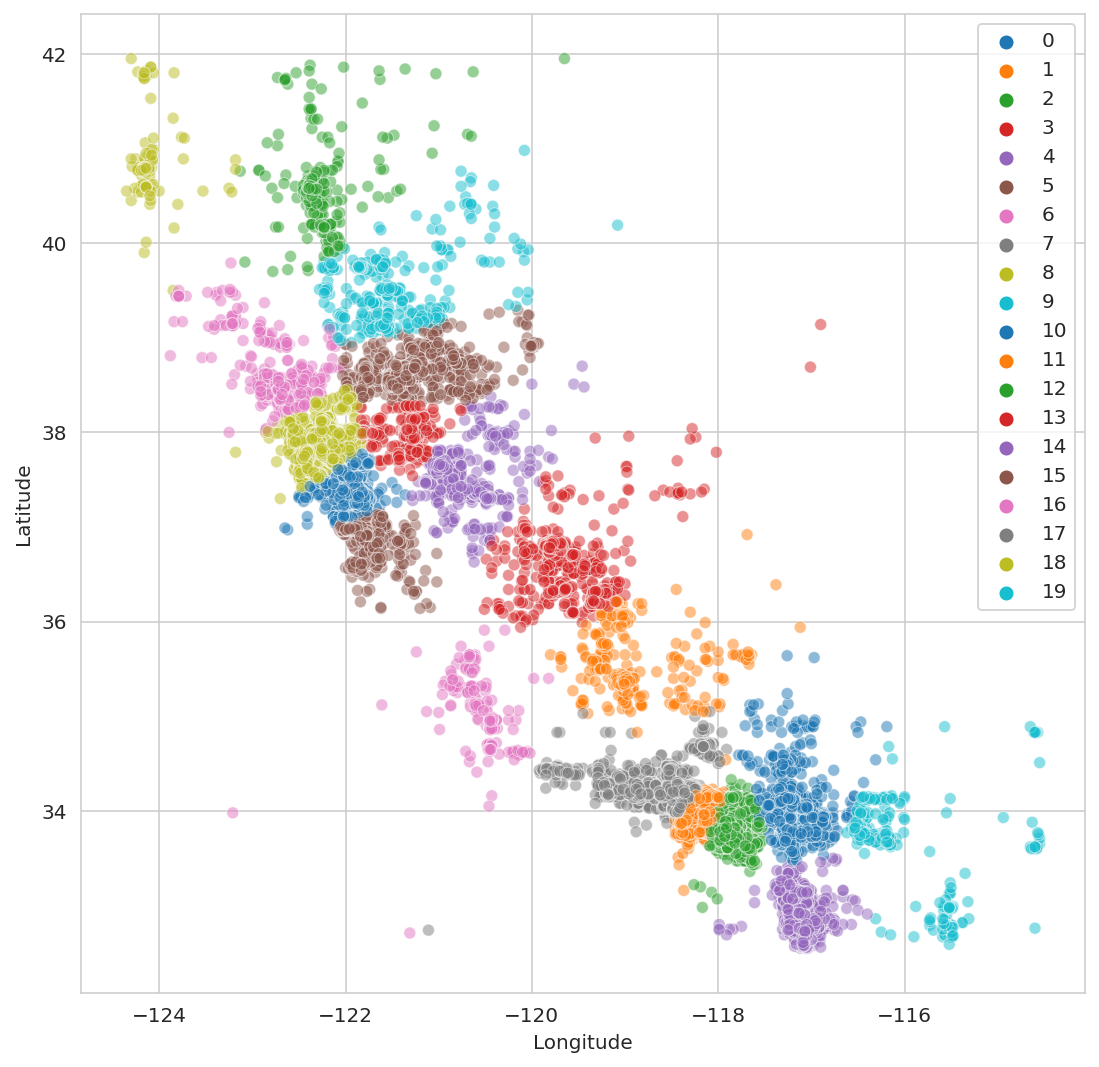

In [24]:
plt.figure(figsize=(9,9))
sns.scatterplot(data=df_train, x='Longitude', y='Latitude', hue=clustering.labels_[:len(df_train)], alpha=0.5, palette='tab10')

In [25]:
# df_train['cluster'] = clustering.labels_[:len(df_train)]
# df_original['cluster'] = clustering.labels_[len(df_train):]
# new_features = features + ['cluster']
# run(new_features, cat_features=list(range(len(features), len(new_features))))

> Doesn't help. Now add distance to centroids instead.

In [26]:
def add_cluster_features(df):
    centers = clustering.cluster_centers_
    for i in range(len(centers)):
        df[f'cluster_{i}'] = df.apply(lambda x: compute_distance((x.Latitude, x.Longitude), centers[i]), axis=1)

    df['cluster_min'] = np.min(df[[f'cluster_{i}' for i in range(len(centers))]])

In [27]:
add_cluster_features(df_train)
add_cluster_features(df_original)
add_cluster_features(df_test)
cluster_features = list(c for c in df_train.columns if c.startswith('cluster_'))
run(features + cluster_features)

Fold 0 rmse: 0.5594
Fold 1 rmse: 0.5621
Fold 2 rmse: 0.5595
Fold 3 rmse: 0.5645
Fold 4 rmse: 0.5525
Fold 5 rmse: 0.554
Fold 6 rmse: 0.5619
Fold 7 rmse: 0.5548
Fold 8 rmse: 0.5654
Fold 9 rmse: 0.559
   OOF rmse: 0.5593


In [28]:
run(features + city_features + coast_features + cluster_features)

Fold 0 rmse: 0.5589
Fold 1 rmse: 0.5602
Fold 2 rmse: 0.5589
Fold 3 rmse: 0.5629
Fold 4 rmse: 0.5507
Fold 5 rmse: 0.554
Fold 6 rmse: 0.5585
Fold 7 rmse: 0.551
Fold 8 rmse: 0.5649
Fold 9 rmse: 0.5557
   OOF rmse: 0.5576


> Awesome!

## Rotation features
https://www.kaggle.com/code/dmitryuarov/ps-s3e1-coordinates-key-to-victory

In [29]:
def rotx(df, angle):
    return (np.cos(np.radians(angle)) * df['Longitude']) - (np.sin(np.radians(angle)) * df['Latitude'])

def roty(df, angle):
    return (np.sin(np.radians(angle)) * df['Longitude']) + (np.cos(np.radians(angle)) * df['Latitude'])

def add_rotation_features(df): 
    # The formula seems wrong but produces better results?!
    df['rot_15_x'] = (np.cos(np.radians(15)) * df['Longitude']) + \
                      (np.sin(np.radians(15)) * df['Latitude'])
    
    df['rot_30_x'] = (np.cos(np.radians(30)) * df['Longitude']) + \
                      (np.sin(np.radians(30)) * df['Latitude'])
    
    df['rot_45_x'] = (np.cos(np.radians(45)) * df['Longitude']) + \
                      (np.sin(np.radians(45)) * df['Latitude'])

#     df['rot_15_x'] = rotx(df, 15)
#     df['rot_30_x'] = rotx(df, 30)
#     df['rot_45_x'] = rotx(df, 45)
#     df['rot_60_x'] = rotx(df, 60)
#     df['rot_15_y'] = roty(df, 15)
#     df['rot_30_y'] = roty(df, 30)
#     df['rot_45_y'] = roty(df, 45)
#     df['rot_60_y'] = roty(df, 60)

In [30]:
add_rotation_features(df_train)
add_rotation_features(df_original)
add_rotation_features(df_test)
rot_features = ['rot_15_x', 'rot_30_x', 'rot_45_x']
run(features + rot_features)

Fold 0 rmse: 0.5606
Fold 1 rmse: 0.5631
Fold 2 rmse: 0.5583
Fold 3 rmse: 0.5625
Fold 4 rmse: 0.5499
Fold 5 rmse: 0.5523
Fold 6 rmse: 0.562
Fold 7 rmse: 0.5573
Fold 8 rmse: 0.5651
Fold 9 rmse: 0.5591
   OOF rmse: 0.559


## Other geo features
r, theta and PCA coords from https://bmanikan.medium.com/feature-engineering-all-i-learned-about-geo-spatial-features-649871d16796

In [31]:
def add_r_theta(dfs):
    for df in dfs:
        df['r'] = np.sqrt(df['Latitude']**2 + df['Longitude']**2)
        df['theta'] = np.arctan2(df['Latitude'], df['Longitude'])
    
add_r_theta([df_train, df_original, df_test])

In [32]:
coords = pd.concat([df_train, df_original])[['Latitude', 'Longitude']].values
pca = PCA().fit(coords)

In [33]:
def add_pca(df, pca):
    df['pca_x'] = pca.transform(df[['Latitude', 'Longitude']].values)[:,0]
    df['pca_y'] = pca.transform(df[['Latitude', 'Longitude']].values)[:,1]

add_pca(df_train, pca)
add_pca(df_original, pca)
add_pca(df_test, pca)

In [34]:
extra_geo_features = ['r', 'theta', 'pca_x', 'pca_y']
run(features + extra_geo_features)

Fold 0 rmse: 0.5628
Fold 1 rmse: 0.5625
Fold 2 rmse: 0.5583
Fold 3 rmse: 0.5648
Fold 4 rmse: 0.5522
Fold 5 rmse: 0.5541
Fold 6 rmse: 0.5644
Fold 7 rmse: 0.5574
Fold 8 rmse: 0.5671
Fold 9 rmse: 0.5581
   OOF rmse: 0.5602


## All features together

In [35]:
all_features = features + city_features + coast_features + cluster_features + rot_features
run(all_features)

Fold 0 rmse: 0.56
Fold 1 rmse: 0.563
Fold 2 rmse: 0.5578
Fold 3 rmse: 0.5623
Fold 4 rmse: 0.5532
Fold 5 rmse: 0.5526
Fold 6 rmse: 0.5606
Fold 7 rmse: 0.5528
Fold 8 rmse: 0.5639
Fold 9 rmse: 0.5585
   OOF rmse: 0.5585


## Tuning

### LightGBM

In [36]:
TUNED_PARAMS = {
    'n_estimators': 6058, 
    'num_leaves': 107, 
    'min_child_samples': 19, 
    'learning_rate': 0.004899729720251191, 
    'log_max_bin': 10, 
    'colsample_bytree': 0.5094776453903889, 
    'reg_alpha': 0.007603254267129311, 
    'reg_lambda': 0.008134379186044243
}

In [37]:
lgbm_models = run(all_features, lgbm_params=TUNED_PARAMS, early_stopping_rounds=100, verbose=False, return_models=True)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: log_max_bin
Fold 0 rmse: 0.5524
[LightGBM] [Warning] Unknown parameter: log_max_bin


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 rmse: 0.5553
[LightGBM] [Warning] Unknown parameter: log_max_bin


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 rmse: 0.5547
[LightGBM] [Warning] Unknown parameter: log_max_bin


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 rmse: 0.5531
[LightGBM] [Warning] Unknown parameter: log_max_bin


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 4 rmse: 0.5423
[LightGBM] [Warning] Unknown parameter: log_max_bin


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 5 rmse: 0.5439
[LightGBM] [Warning] Unknown parameter: log_max_bin


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 6 rmse: 0.5517
[LightGBM] [Warning] Unknown parameter: log_max_bin


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 7 rmse: 0.545
[LightGBM] [Warning] Unknown parameter: log_max_bin


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 8 rmse: 0.5537
[LightGBM] [Warning] Unknown parameter: log_max_bin


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 9 rmse: 0.5493
   OOF rmse: 0.5502


### CatBoost

In [38]:
def run_catboost(features, params=None, return_models=False, verbose=0):
    X_train, y_train = df_train[features].values, df_train[target].values
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    oof = np.zeros(len(X_train))
    models = []
    X_org, y_org = df_original[features].values, df_original[target].values

    for fold, (idx_tr, idx_vl) in enumerate(cv.split(X_train)):
        X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]
        # Add the entire original data to each fold
        X_tr = np.vstack((X_tr, X_org))
        y_tr = np.hstack((y_tr, y_org))
        # ... while keeping train data as validation
        X_vl, y_vl = X_train[idx_vl], y_train[idx_vl]

        model = CatBoostRegressor(**params)
        eval_set = [(X_vl, y_vl)]
        model.fit(X_tr, y_tr, eval_set=eval_set, early_stopping_rounds=params['early_stopping_rounds'], verbose=verbose)
        oof[idx_vl] = model.predict(X_vl)
        models.append(model)

        r = mse(y_vl, oof[idx_vl], squared=False)
        print(f'Fold {fold} rmse: {r:.4}')

    print(f'   OOF rmse: {mse(y_train, oof, squared=False):.4}')
    
    if return_models:
        return models

In [39]:
# https://www.kaggle.com/code/alexandershumilin/playground-series-s3-e1-catboost-xgboost-lgbm
CB = {
    'n_estimators': 15000,
    'early_stopping_rounds': 1000,
    'random_seed': 0
}

cb_models = run_catboost(all_features, params=CB, return_models=True)

Fold 0 rmse: 0.5536
Fold 1 rmse: 0.5556
Fold 2 rmse: 0.5557
Fold 3 rmse: 0.5566
Fold 4 rmse: 0.5442
Fold 5 rmse: 0.5469
Fold 6 rmse: 0.5544
Fold 7 rmse: 0.5443
Fold 8 rmse: 0.5582
Fold 9 rmse: 0.5513
   OOF rmse: 0.5521


## xgboost

In [40]:
def run_xgboost(features, params=None, return_models=False, verbose=0):
    X_train, y_train = df_train[features].values, df_train[target].values
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    oof = np.zeros(len(X_train))
    models = []
    X_org, y_org = df_original[features].values, df_original[target].values

    for fold, (idx_tr, idx_vl) in enumerate(cv.split(X_train)):
        X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]
        # Add the entire original data to each fold
        X_tr = np.vstack((X_tr, X_org))
        y_tr = np.hstack((y_tr, y_org))
        # ... while keeping train data as validation
        X_vl, y_vl = X_train[idx_vl], y_train[idx_vl]

        model = XGBRegressor(**params)
        eval_set = [(X_vl, y_vl)]
        model.fit(X_tr, y_tr, eval_set=eval_set, verbose=verbose)
        oof[idx_vl] = model.predict(X_vl)
        models.append(model)

        r = mse(y_vl, oof[idx_vl], squared=False)
        print(f'Fold {fold} rmse: {r:.4}')

    print(f'   OOF rmse: {mse(y_train, oof, squared=False):.4}')
    
    if return_models:
        return models

In [41]:
# https://www.kaggle.com/code/dmitryuarov/ps-s3e1-coordinates-key-to-victory#-XGB
XGB_PARAMS = {
    'n_estimators': 50000,
    'max_depth': 9,
    'learning_rate': 0.01,
    'colsample_bytree': 0.66,
    'subsample': 0.76,
    'min_child_weight': 22,
    'reg_lambda': 16,
    'early_stopping_rounds': 1000,
    'eval_metric': 'rmse',
    'seed': 0
}

xgb_models = run_xgboost(all_features, params=XGB_PARAMS, return_models=True)

Fold 0 rmse: 0.554
Fold 1 rmse: 0.5548
Fold 2 rmse: 0.5549
Fold 3 rmse: 0.5566
Fold 4 rmse: 0.5431
Fold 5 rmse: 0.5439
Fold 6 rmse: 0.5539
Fold 7 rmse: 0.5446
Fold 8 rmse: 0.5557
Fold 9 rmse: 0.5515
   OOF rmse: 0.5513


## AutoML
Compare different auto ML frameworks in 10 minutes.

In [42]:
df_tr, df_val = train_test_split(df_train, test_size=0.2, random_state=0)
df_tr = pd.concat([df_tr, df_original])
X_tr, y_tr = df_tr[all_features].values, df_tr[target].values
X_val, y_val = df_val[all_features].values, df_val[target].values

### Baseline

In [43]:
# auto_flaml = flaml.AutoML()
# auto_flaml.fit(X_tr, y_tr, task='regression', metric='rmse', time_budget=60*60, verbose=0)
# print(mse(y_val, auto_flaml.predict(X_val), squared=False))
# print(auto_flaml.best_estimator)
# pprint(auto_flaml.best_config)

### AutoGluon

In [44]:
# Train with all data, skip validation
# combined_df = pd.concat([df_train, df_original]).drop(columns=['cluster'])
# predictor = TabularPredictor(label='MedHouseVal', problem_type='regression', eval_metric='root_mean_squared_error')
# predictor.fit(combined_df, time_limit=60*1, presets='best_quality', verbosity=0)

## Submit

In [45]:
def submit(models, name):
    y_preds = np.mean([m.predict(df_test[all_features].values) for m in models], axis=0)
    submission = pd.DataFrame(data={'id': df_test.index, target: y_preds})
    submission.loc[submission[target].gt(5), target] = 5
    submission.to_csv(f'submission_{name}.csv', index=None)

In [46]:
submit(lgbm_models, 'lgbm')
submit(cb_models, 'cb')
submit(xgb_models, 'xgb')

In [47]:
df_cb = pd.read_csv('/kaggle/input/distance-to-key-locations/submission_cb.csv', index_col=0)
df_xgb = pd.read_csv('/kaggle/input/distance-to-key-locations/submission_xgb.csv', index_col=0)
df_lgbm = pd.read_csv('/kaggle/input/distance-to-key-locations/submission_lgbm.csv', index_col=0)

In [48]:
target = 'MedHouseVal'
df = df_lgbm
df[target] = df_lgbm[target] * 0.4 + df_cb[target] * 0.31 + df_xgb[target] * 0.29
df.to_csv('submission.csv')